In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import numpy as np
import allel
import itertools
import os
from subprocess import call
from tqdm import tqdm, trange

import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #allows multiple outputs

#### List file for GATK

In [2]:
path_folder_2 = '/data3/TaeFile/Pol_HeaderedVcf/'

interval_list =[]    

for file in tqdm(os.listdir(path_folder_2), total=len(path_folder_2)):
    info = file.split('_headered')[0]
    contig = info.split('_')[0]
    start = info.split('_')[1]
    start_int = int(start)
    end = start_int + 99999
    interval_list.append([contig, start, end])

2096it [00:00, 178785.92it/s]         


In [3]:
polistes_interval = pd.DataFrame(interval_list)
polistes_interval.head()

,0,1,2
0,PdomSCFr1.2-0158,100000,199999
1,PdomSCFr1.2-0024,0,99999
2,PdomSCFr1.2-0001,5500000,5599999
3,PdomSCFr1.2-0157,0,99999
4,PdomSCFr1.2-0038,1300000,1399999


In [4]:
polistes_interval.rename(columns={
    0:"Contig", 1:"Start", 2:"Stop"}, inplace=True)

In [5]:
polistes_interval.head()

,Contig,Start,Stop
0,PdomSCFr1.2-0158,100000,199999
1,PdomSCFr1.2-0024,0,99999
2,PdomSCFr1.2-0001,5500000,5599999
3,PdomSCFr1.2-0157,0,99999
4,PdomSCFr1.2-0038,1300000,1399999


In [6]:
polistes_interval.sort_values(by=['Contig', 'Start'], inplace=True)
polistes_interval.head()

,Contig,Start,Stop
1443,PdomSCFr1.2-0001,0,99999
1881,PdomSCFr1.2-0001,100000,199999
1970,PdomSCFr1.2-0001,1000000,1099999
248,PdomSCFr1.2-0001,1100000,1199999
1207,PdomSCFr1.2-0001,1200000,1299999


In [7]:
#polistes_interval.to_csv('/data3/TaeFile/Pdom_good_intervals.bed', sep='\t', index=False, header=False)
#run only once!

In [8]:
test1 = polistes_interval.groupby("Contig", as_index=False).apply(lambda x: x.iloc[:-1])
test1.head(10)

Contig    Start     Stop
0 1443  PdomSCFr1.2-0001        0    99999
  1881  PdomSCFr1.2-0001   100000   199999
  1970  PdomSCFr1.2-0001  1000000  1099999
  248   PdomSCFr1.2-0001  1100000  1199999
  1207  PdomSCFr1.2-0001  1200000  1299999
  246   PdomSCFr1.2-0001  1300000  1399999
  587   PdomSCFr1.2-0001  1400000  1499999
  1655  PdomSCFr1.2-0001  1500000  1599999
  796   PdomSCFr1.2-0001  1600000  1699999
  349   PdomSCFr1.2-0001  1700000  1799999

### Take the GC by interval file and edit contig ID to fit the old dataframe ID, For Bimp

In [10]:
BimpGC_raw = pd.read_csv('/home/taeyoon/GCContent/BimpGC_V2.txt', sep='\t', header=None)

In [11]:
BimpGC_raw.head()

,0,1
0,NT_176427.1:1-99999,0.296453
1,NT_176427.1:100001-199999,0.260573
2,NT_176427.1:200001-270154,0.296548
3,NT_176429.1:1-99999,0.369374
4,NT_176429.1:100001-199999,0.401534


In [12]:
BimpGC_raw.rename(columns ={0:"ID", 1:"GC_Content"}, inplace =True)
BimpGC_raw.head()

,ID,GC_Content
0,NT_176427.1:1-99999,0.296453
1,NT_176427.1:100001-199999,0.260573
2,NT_176427.1:200001-270154,0.296548
3,NT_176429.1:1-99999,0.369374
4,NT_176429.1:100001-199999,0.401534


In [13]:
BimpGC_raw['ID'] = BimpGC_raw['ID'].str.split('1-').str.get(0)
BimpGC_raw.head()

,ID,GC_Content
0,NT_176427.1:,0.296453
1,NT_176427.1:10000,0.260573
2,NT_176427.1:20000,0.296548
3,NT_176429.1:,0.369374
4,NT_176429.1:10000,0.401534


In [14]:
BimpGC_raw['ID'] = BimpGC_raw['ID'] + '0' #make sure to run once at a time, or else it'll add more zeros
BimpGC_raw.head()

,ID,GC_Content
0,NT_176427.1:0,0.296453
1,NT_176427.1:100000,0.260573
2,NT_176427.1:200000,0.296548
3,NT_176429.1:0,0.369374
4,NT_176429.1:100000,0.401534


In [15]:
BimpGC_raw_front = BimpGC_raw['ID'].str.split(':').str.get(0)
BimpGC_raw_back = BimpGC_raw['ID'].str.split(':').str.get(1)
BimpGC_raw['ID'] = BimpGC_raw_front + '_' + BimpGC_raw_back
BimpGC_raw.head()

,ID,GC_Content
0,NT_176427.1_0,0.296453
1,NT_176427.1_100000,0.260573
2,NT_176427.1_200000,0.296548
3,NT_176429.1_0,0.369374
4,NT_176429.1_100000,0.401534


In [16]:
#output and save a copy of this dataframe
#BimpGC_raw.to_csv('/home/taeyoon/GCContent/BimpGC_ready.csv', sep='\t', index=False)
#run once and once only, unless change is made and needs to overwrite the file

### Same thing for Pdom

In [17]:
PdomGC_raw = pd.read_csv('/home/taeyoon/GCContent/PdomGC_V1.txt', sep='\t', header=None)
PdomGC_raw.head()

,0,1
0,PdomSCFr1.2-0001:1-99999,0.392744
1,PdomSCFr1.2-0001:100001-199999,0.415594
2,PdomSCFr1.2-0001:200001-299999,0.350644
3,PdomSCFr1.2-0001:300001-399999,0.321123
4,PdomSCFr1.2-0001:400001-499999,0.327853


In [18]:
PdomGC_raw.rename(columns={0:'ID', 1:'GC_Content'}, inplace=True)
PdomGC_raw.head()

,ID,GC_Content
0,PdomSCFr1.2-0001:1-99999,0.392744
1,PdomSCFr1.2-0001:100001-199999,0.415594
2,PdomSCFr1.2-0001:200001-299999,0.350644
3,PdomSCFr1.2-0001:300001-399999,0.321123
4,PdomSCFr1.2-0001:400001-499999,0.327853


In [19]:
PdomGC_raw['ID'] = PdomGC_raw['ID'].str.split('1-').str.get(0)
PdomGC_raw.head()

,ID,GC_Content
0,PdomSCFr1.2-0001:,0.392744
1,PdomSCFr1.2-0001:10000,0.415594
2,PdomSCFr1.2-0001:20000,0.350644
3,PdomSCFr1.2-0001:30000,0.321123
4,PdomSCFr1.2-0001:40000,0.327853


In [20]:
PdomGC_raw['ID'] = PdomGC_raw['ID'] + '0'
PdomGC_raw.head()

,ID,GC_Content
0,PdomSCFr1.2-0001:0,0.392744
1,PdomSCFr1.2-0001:100000,0.415594
2,PdomSCFr1.2-0001:200000,0.350644
3,PdomSCFr1.2-0001:300000,0.321123
4,PdomSCFr1.2-0001:400000,0.327853


In [21]:
PdomGC_raw_front = PdomGC_raw['ID'].str.split(':').str.get(0)
PdomGC_raw_back = PdomGC_raw['ID'].str.split(':').str.get(1)
PdomGC_raw['ID'] = PdomGC_raw_front + '_' + PdomGC_raw_back
PdomGC_raw.head()

,ID,GC_Content
0,PdomSCFr1.2-0001_0,0.392744
1,PdomSCFr1.2-0001_100000,0.415594
2,PdomSCFr1.2-0001_200000,0.350644
3,PdomSCFr1.2-0001_300000,0.321123
4,PdomSCFr1.2-0001_400000,0.327853


In [22]:
#output the file
#PdomGC_raw.to_csv('/home/taeyoon/GCContent/PdomGC_ready.csv', sep='\t', index=False)
#run only once!

### Merge Old Dataframe with new Info, First Bimp

In [55]:
Bombus_df = pd.read_csv('/home/taeyoon/GCContent/BombusDataframe.csv')
Bombus_df.head()

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
0,NT_177880.1_900000,0.478757,0.428571,471,304,101,876,262,119,71,87
1,NT_179893.1_1300000,0.549740,0.428571,353,197,68,618,208,89,54,53
2,NT_176548.1_300000,0.464233,0.428571,371,133,54,558,245,69,22,26
3,NT_176871.1_300000,0.414016,0.285714,386,210,85,681,235,108,33,37
4,NT_176837.1_300000,0.563966,0.444444,566,368,117,1051,289,152,97,87


In [56]:
Bombus_GC = pd.read_csv('/home/taeyoon/GCContent/BimpGC_ready.csv', sep='\t')
Bombus_GC.head()

,ID,GC_Content
0,NT_176427.1_0,0.296453
1,NT_176427.1_100000,0.260573
2,NT_176427.1_200000,0.296548
3,NT_176429.1_0,0.369374
4,NT_176429.1_100000,0.401534


In [57]:
#merge!
Bombus_big_df = pd.merge(Bombus_df, Bombus_GC, how='left', on=['ID'])
#merge on key only present in Bombus_df, if the particular window exists in GC_df only, I don't want it.

In [58]:
Bombus_big_df.head()

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common,GC_Content
0,NT_177880.1_900000,0.478757,0.428571,471,304,101,876,262,119,71,87,0.351114
1,NT_179893.1_1300000,0.549740,0.428571,353,197,68,618,208,89,54,53,0.360864
2,NT_176548.1_300000,0.464233,0.428571,371,133,54,558,245,69,22,26,0.489595
3,NT_176871.1_300000,0.414016,0.285714,386,210,85,681,235,108,33,37,0.399884
4,NT_176837.1_300000,0.563966,0.444444,566,368,117,1051,289,152,97,87,0.360534


#### Graph, GC and R^2 relationship

<Figure size 1152x432 with 0 Axes>

(0, 1)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinregressResult(slope=-0.06473529250983949, intercept=0.40962442138891564, rvalue=-0.24413293739214795, pvalue=3.5344677930762416e-33, stderr=0.005311192458210555)

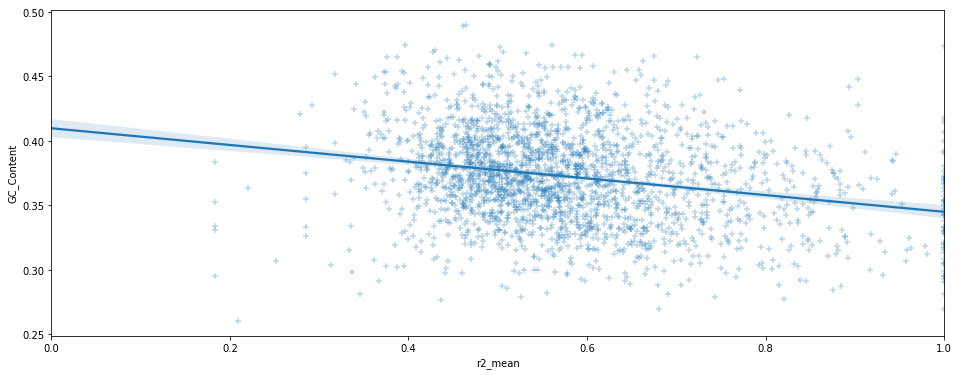

In [27]:
plt.figure(figsize=(16,6))
plt.xlim(0,1)
sns.regplot(Bombus_big_df['r2_mean'], Bombus_big_df['GC_Content'], marker="+", scatter_kws={'alpha':0.3}) #blue
scipy.stats.linregress(Bombus_big_df['r2_mean'], Bombus_big_df['GC_Content'])

### Merge Dataframe, Pdom

In [59]:
Polistes_df = pd.read_csv('/home/taeyoon/GCContent/PolistesDataframe.csv')
Polistes_df.head()

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
0,PdomSCFr1.2-0173_100000,0.246808,0.079546,688,456,327,1471,384,186,82,105
1,PdomSCFr1.2-0115_200000,0.251666,0.092593,851,648,391,1890,454,271,118,138
2,PdomSCFr1.2-0030_300000,0.396516,0.200820,236,154,108,498,105,60,16,17
3,PdomSCFr1.2-0025_2000000,0.335720,0.111111,756,471,309,1536,503,266,91,105
4,PdomSCFr1.2-0034_1400000,0.252937,0.079365,626,456,246,1328,395,206,57,104


In [60]:
Polistes_GC = pd.read_csv('/home/taeyoon/GCContent/PdomGC_ready.csv', sep='\t')
Polistes_GC.head()

,ID,GC_Content
0,PdomSCFr1.2-0001_0,0.392744
1,PdomSCFr1.2-0001_100000,0.415594
2,PdomSCFr1.2-0001_200000,0.350644
3,PdomSCFr1.2-0001_300000,0.321123
4,PdomSCFr1.2-0001_400000,0.327853


In [61]:
#merge!
Polistes_big_df = pd.merge(Polistes_df, Polistes_GC, how='left', on=['ID'])
Polistes_big_df.head()

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common,GC_Content
0,PdomSCFr1.2-0173_100000,0.246808,0.079546,688,456,327,1471,384,186,82,105,0.289281
1,PdomSCFr1.2-0115_200000,0.251666,0.092593,851,648,391,1890,454,271,118,138,0.233172
2,PdomSCFr1.2-0030_300000,0.396516,0.200820,236,154,108,498,105,60,16,17,0.273633
3,PdomSCFr1.2-0025_2000000,0.335720,0.111111,756,471,309,1536,503,266,91,105,0.308193
4,PdomSCFr1.2-0034_1400000,0.252937,0.079365,626,456,246,1328,395,206,57,104,0.336833


In [62]:
len(Polistes_big_df)

2095

In [63]:
Polistes_big_df.dropna();

In [64]:
len(Polistes_big_df) #drop na does not reduce length. No NaN present in the original dataframe

2095

#### Graph relationship between R2 mean and GC%

<Figure size 1152x432 with 0 Axes>

(0, 1)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinregressResult(slope=-0.032637799087265454, intercept=0.3071118579967254, rvalue=-0.10663923519585225, pvalue=9.979390992104604e-07, stderr=0.006651746628016832)

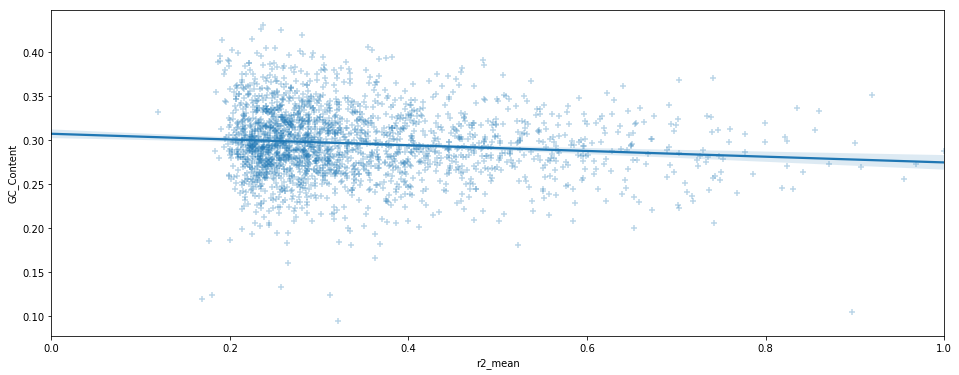

In [65]:
plt.figure(figsize=(16,6))
plt.xlim(0,1)
sns.regplot(Polistes_big_df['r2_mean'], Polistes_big_df['GC_Content'], marker="+", scatter_kws={'alpha':0.3}) #blue
scipy.stats.linregress(Polistes_big_df['r2_mean'], Polistes_big_df['GC_Content'])

### Combined Graph

<Figure size 864x432 with 0 Axes>

(0, 1)

(0, 0.75)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'GC% Content Per Window')

Text(0.5,0,'R^2 Mean')

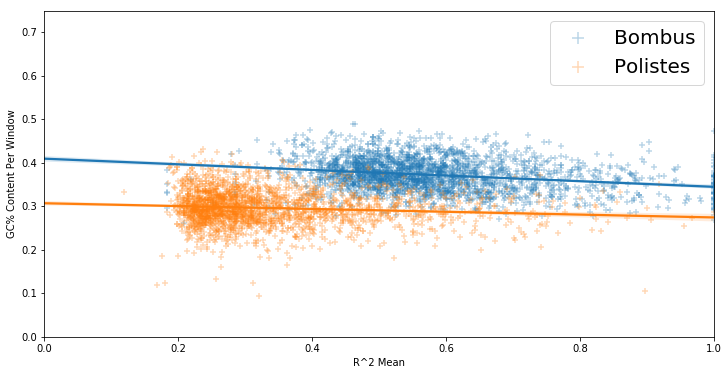

In [72]:
plt.figure(figsize=(12,6))
plt.xlim(0,1)
plt.ylim(0,0.75)

sns.regplot(Bombus_big_df['r2_mean'], Bombus_big_df['GC_Content'], marker="+", 
            scatter_kws={'alpha':0.3}, label='Bombus') #blue

sns.regplot(Polistes_big_df['r2_mean'], Polistes_big_df['GC_Content'], marker="+", 
            scatter_kws={'alpha':0.3}, label='Polistes') #orange

plt.ylabel('GC% Content Per Window')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [67]:
scipy.stats.linregress(Bombus_big_df['r2_mean'], Bombus_big_df['GC_Content']) #blue

LinregressResult(slope=-0.06473529250983949, intercept=0.40962442138891564, rvalue=-0.24413293739214795, pvalue=3.5344677930762416e-33, stderr=0.005311192458210555)

In [68]:
scipy.stats.linregress(Polistes_big_df['r2_mean'], Polistes_big_df['GC_Content']) #orange

LinregressResult(slope=-0.032637799087265454, intercept=0.3071118579967254, rvalue=-0.10663923519585225, pvalue=9.979390992104604e-07, stderr=0.006651746628016832)

In [69]:
len(Polistes_big_df)

2095

In [38]:
#Z-test for coefficients (slopes)
def Z_score(slope1, std_error1, slope2, std_error2):
    numerator = (slope1 - slope2)
    denominator = pow((pow(std_error1,2) + pow(std_error2,2)), 1/2)
    Z = (numerator) / (denominator)
    return Z

In [71]:
Z_score(-0.06473529250983949, 0.005311192458210555, -0.032637799087265454, 0.006651746628016832)
#Z score is -3.770842915106372
#p-value is 0.000163, reject null, slope difference is significant

-3.770842915106372